# Paso 1: Limpieza del Dataset

1. Renombre la columna "default payment next month" a "default".
2. Remueva la columna "ID".
3. Elimine los registros con informacion no disponible.
4. Para la columna EDUCATION, valores > 4 indican niveles superiores de educación, agrupe estos valores en la categoría "others". 

In [1]:
# Leer Dataset

import pandas as pd

train = pd.read_csv("../files/input/train_data.csv.zip", index_col = False, compression = "zip")
test = pd.read_csv("../files/input/test_data.csv.zip", index_col = False, compression = "zip")

In [2]:
# Renombre la columna "default payment next month" a "default"
train.rename(columns={"default payment next month": "default"}, inplace=True)
test.rename(columns={"default payment next month": "default"}, inplace=True)

In [3]:
# Remueva la columna "ID"
train.drop(columns=["ID"], inplace=True)
test.drop(columns=["ID"], inplace=True)

In [4]:
# Elimine los registros con informacion no disponible.
train = train.loc[train['EDUCATION'] != 0]
test = test.loc[test['EDUCATION'] != 0]

train = train.loc[train['MARRIAGE'] != 0]
test = test.loc[test['MARRIAGE'] != 0]

In [5]:
# Para la columna EDUCATION, valores > 4 indican niveles superiores
# de educación, agrupe estos valores en la categoría "others".
train.loc[train['EDUCATION'] > 4, 'EDUCATION'] = 4
test.loc[test['EDUCATION'] > 4, 'EDUCATION'] = 4

In [6]:
train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

# Paso 2: División del Dataset

1. Divida los datasets en x_train, y_train, x_test, y_test.

In [7]:
x_train = train.drop(columns=['default'])
y_train = train['default']

x_test = test.drop(columns=['default'])
y_test = test['default']

# Paso 3: Pipeline para el modelo de Clasificación

1. Transforma las variables categoricas usando el método one-hot-encoding.
2. Escala las demas variables al intervalo [0, 1].
3. Selecciona las K mejores caracteristicas.
4. Ajusta un modelo de regresion logistica.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Identificar columnas categóricas y numéricas
categoricas = ['SEX', 'EDUCATION', 'MARRIAGE']
numericas = [col for col in x_train.columns if col not in categoricas]

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categoricas),
        ('num', MinMaxScaler(), numericas)
    ],
    remainder="passthrough"
)

#Selección de las k mejores características
k_best = SelectKBest(score_func=f_classif)

LR = LogisticRegression(42)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', k_best), 
    ('classifier', LR)  
])

# Paso 4: Optimización

1. Optimice los hiperparametros del pipeline usando validación cruzada.
2. Use 10 splits para la validación cruzada. 

    Use la función de precision balanceada para medir la precisión del modelo.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score

param_grid = {
    'feature_selection__k': [1, 3, 5, 7, 10],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__max_iter': [100,200]
}

model=GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True
    )

model.fit(x_train, y_train)

print(f"Mejores parámetros: {model.best_params_}")
print(f"Precisión: {model.best_score_}")

c:\Users\Asus\Documents\GitHub\20204-2-LAB-02-prediccion-del-default-usando-logreg-nathalygarzon\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
600 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Asus\Documents\GitHub\20204-2-LAB-02-prediccion-del-default-usando-logreg-nathalygarzon\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Asus\Documents\GitHub\20204-2-LAB-02-prediccion-del-default-usando-logreg-nathalygarzon\.venv\Lib\site-packages\sklearn\base.py", lin

Mejores parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'feature_selection__k': 1}
Precisión: 0.6392688664250823


# Paso 5: Guardar el Modelo

1. Guarde el modelo (comprimido con gzip) como "files/models/model.pkl.gz". 

    Recuerde que es posible guardar el modelo comprimido usanzo la libreria gzip.

In [12]:
import gzip
import pickle
import os

models_dir = '../files/models'
os.makedirs(models_dir, exist_ok=True)
output_path = "../files/models/model.pkl.gz"
with gzip.open(output_path, 'wb') as file:
    pickle.dump(model, file)

# Paso 6: Métricas

1. Calcule las metricas de precision, precision balanceada, recall y f1-score para los conjuntos de entrenamiento y prueba.
2. Guardelas en el archivo files/output/metrics.json. 

    Cada fila del archivo es un diccionario con las metricas de un modelo. Este diccionario tiene un campo para indicar si es el conjunto de entrenamiento o prueba. Por ejemplo:

{'type': 'metrics', 'dataset': 'train', 'precision': 0.8, 'balanced_accuracy': 0.7, 'recall': 0.9, 'f1_score': 0.85}

{'type': 'metrics', 'dataset': 'test', 'precision': 0.7, 'balanced_accuracy': 0.6, 'recall': 0.8, 'f1_score': 0.75}


In [13]:
from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, f1_score

# Realizar las predicciones sobre los conjuntos de entrenamiento y prueba
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Calcular métricas para el conjunto de entrenamiento
precision_train = precision_score(y_train, y_train_pred)
balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

# Calcular métricas para el conjunto de prueba
precision_test = precision_score(y_test, y_test_pred)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Mostrar los resultados
print("Métricas para el conjunto de entrenamiento:")
print(f"Precisión: {precision_train:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-score: {f1_train:.4f}")

print("\nMétricas para el conjunto de prueba:")
print(f"Precisión: {precision_test:.4f}")
print(f"Precisión balanceada: {balanced_accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-score: {f1_test:.4f}")


Métricas para el conjunto de entrenamiento:
Precisión: 0.6939
Precisión balanceada: 0.6393
Recall: 0.3196
F1-score: 0.4376

Métricas para el conjunto de prueba:
Precisión: 0.7018
Precisión balanceada: 0.6547
Recall: 0.3494
F1-score: 0.4665


In [22]:
# Guardar las métricas en un archivo json

import json

metrics = [
    {
        "type": "metrics",
        'dataset': 'train',
        'precision': precision_train,
        'balanced_accuracy': balanced_accuracy_train,
        'recall': recall_train,
        'f1_score': f1_train,
    },
    {
        "type": "metrics",
        'dataset': 'test',
        'precision': precision_test,
        'balanced_accuracy': balanced_accuracy_test,
        'recall': recall_test,
        'f1_score': f1_test,
    }
]

output_dir = "../files/output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir,"metrics.json")

with open(output_path,"w") as file:
        file.write(json.dumps(metrics) + '\n')


# Paso 7: Matrices de Confusion

1. Calcule las matrices de confusion para los conjuntos de entrenamiento y prueba. 

2. Guardelas en el archivo files/output/metrics.json. 
    
    Cada fila del archivo es un diccionario con las metricas de un modelo de entrenamiento o prueba. Por ejemplo:

{'type': 'cm_matrix', 'dataset': 'train', 'true_0': {"predicted_0": 15562, "predicte_1": 666}, 'true_1': {"predicted_0": 3333, "predicted_1": 1444}}

{'type': 'cm_matrix', 'dataset': 'test', 'true_0': {"predicted_0": 15562, "predicte_1": 650}, 'true_1': {"predicted_0": 2490, "predicted_1": 1420}}


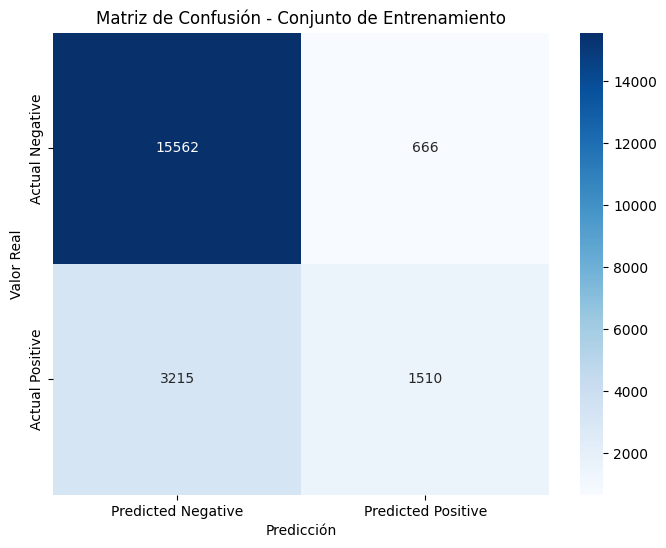

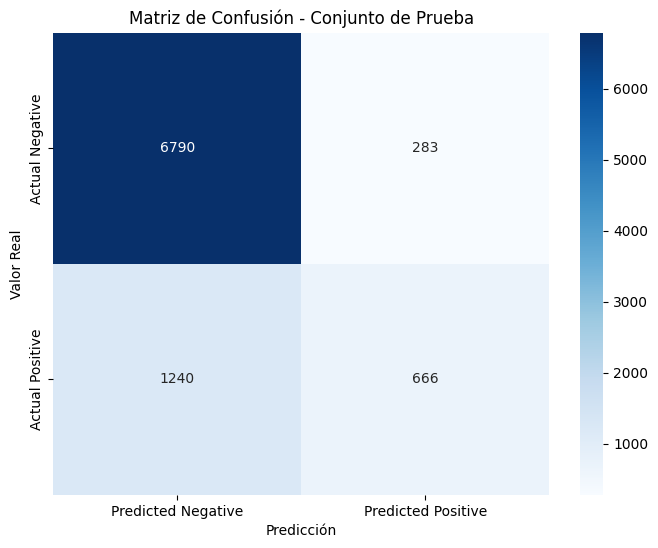

In [18]:
#Calcule las matrices de confusion para los conjuntos de entrenamiento y prueba.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión para el conjunto de entrenamiento
matriz_train = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_train, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Matriz de confusión para el conjunto de prueba
matriz_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_test, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [25]:
# Guardar las matrices en un archivo json

matriz_metrics = [
    {
        'type': 'cm_matrix',
        'dataset': 'train',
        'true_0': {'predicted_0': int(matriz_train[0, 0]),'predicted_1': int(matriz_train[0, 1])},
        'true_1': {'predicted_0': int(matriz_train[1, 0]), 'predicted_1': int(matriz_train[1, 1])},
    },
    {
        'type': 'cm_matrix',
        'dataset': 'test',
        'true_0': {'predicted_0': int(matriz_test[0, 0]), 'predicted_1': int(matriz_test[0, 1])},
        'true_1': {'predicted_0': int(matriz_test[1, 0]), 'predicted_1': int(matriz_test[1, 1])},
    },
]

metrics.extend(matriz_metrics)

output_path = "../files/output/metrics.json"

with open(output_path, 'w', encoding="utf-8") as file:
    for obj in metrics:
        file.write(json.dumps(obj) + "\n")


In [26]:
with open("../files/output/metrics.json", "r") as file:
    contenido = file.read()
    print("Contenido del archivo JSON:")
    print(contenido)

Contenido del archivo JSON:
{"type": "metrics", "dataset": "train", "precision": 0.6939338235294118, "balanced_accuracy": 0.6392682710528409, "recall": 0.31957671957671957, "f1_score": 0.43761773655991887}
{"type": "metrics", "dataset": "test", "precision": 0.7017913593256059, "balanced_accuracy": 0.6547057822566611, "recall": 0.34942287513116477, "f1_score": 0.46654991243432575}
{"type": "cm_matrix", "dataset": "train", "true_0": {"predicted_0": 15562, "predicted_1": 666}, "true_1": {"predicted_0": 3215, "predicted_1": 1510}}
{"type": "cm_matrix", "dataset": "test", "true_0": {"predicted_0": 6790, "predicted_1": 283}, "true_1": {"predicted_0": 1240, "predicted_1": 666}}
{"type": "cm_matrix", "dataset": "train", "true_0": {"predicted_0": 15562, "predicted_1": 666}, "true_1": {"predicted_0": 3215, "predicted_1": 1510}}
{"type": "cm_matrix", "dataset": "test", "true_0": {"predicted_0": 6790, "predicted_1": 283}, "true_1": {"predicted_0": 1240, "predicted_1": 666}}

